In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
train_ds, test_ds = tfds.load('sentiment140',
                              split=['train', 'test'],
                              as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Shuffling sentiment140-train.tfrecord...:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/498 [00:00<?, ? examples/s]

Shuffling sentiment140-test.tfrecord...:   0%|          | 0/498 [00:00<?, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/tensorflow_datasets/sentiment140/1.0.0. Subsequent calls will reuse this data.


In [3]:
for ex, label in train_ds.take(1):
    print(f"text: {ex.numpy()}\nlabel: {label.numpy()}")

text: b"i'm 10x cooler than all of you! "
label: 4


In [4]:
def ds2df(ds):
    df = []
    for ex, label in tqdm(ds):
        df.append([ex.numpy().decode('utf-8'), label.numpy()])
    df = pd.DataFrame(df, columns=['text', 'label'])
    return df

In [5]:
from tqdm import tqdm
df = ds2df(train_ds)
df

100%|██████████| 1600000/1600000 [09:21<00:00, 2847.16it/s]


,text,label
0,i'm 10x cooler than all of you!,4
1,O.kk? Thats weird I cant stop following people...,0
2,what a beautiful day not to got to my first cl...,4
3,.@HildyGottlieb &amp; I was just saying to Mah...,4
4,kinda sad and confused why do guys do this?,0
...,...,...
1599995,@nicolerichie I too sleep diagonally with my b...,0
1599996,@Leah923 &quot;Yeah Eric&quot; is an inside jo...,4
1599997,@cswtham Growl is a kind of notification thing...,4
1599998,A coffee and some formula diet pulver is a goo...,0


([<matplotlib.axis.XTick at 0x7f96d2b67190>,
 [Text(0, 0, 'pos'), Text(1, 0, 'neg')])

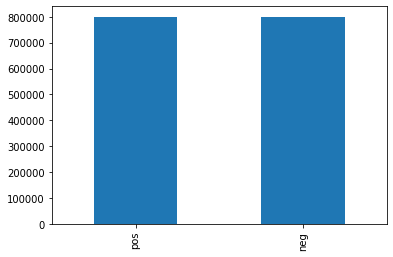

In [6]:
df['label'].value_counts().plot.bar()
plt.xticks([0, 1], ['pos', 'neg'])

In [7]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def text_preprocessing(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, " ", str(text).lower()).strip()
    tokens = []
    
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
df.text = df.text.apply(lambda x: text_preprocessing(x))

In [9]:
!pip install wordcloud

In [10]:
from wordcloud import WordCloud

def plt_word(type):
    df_plot = df[df.label == type]
    word_all = " ".join(text for text in df_plot.text)
    reg = r"[a-zA-Z']+"
    wordcloud = WordCloud(background_color = 'white', max_words=2000, height = 2000, width=4000, regexp=reg).generate(word_all)
    plt.figure(figsize = (16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

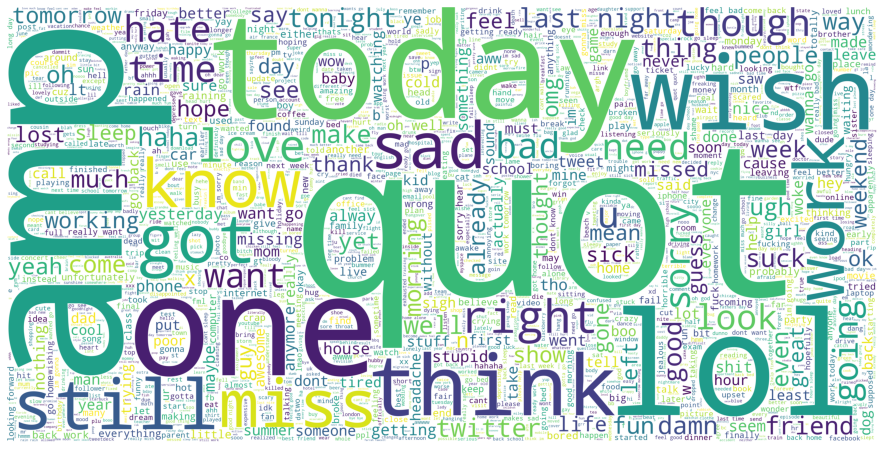

In [11]:
plt_word(0)

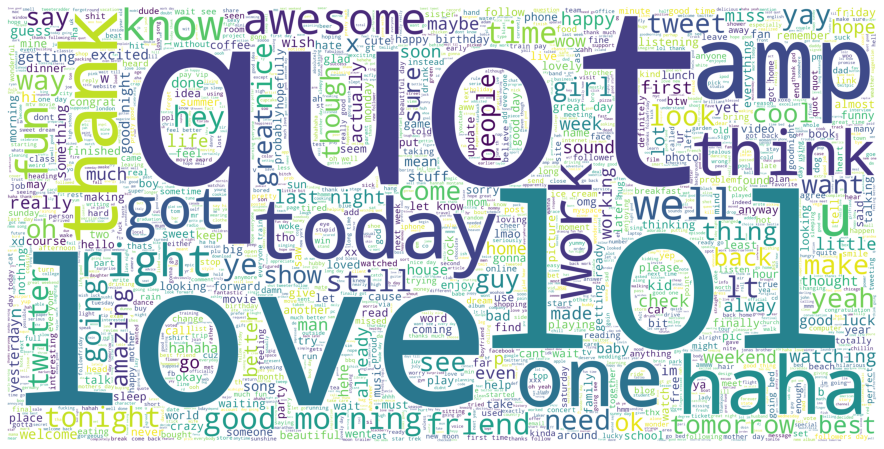

In [12]:
plt_word(4)

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=5e-2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1520000
TEST size: 80000


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {VOCAB_SIZE}')

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text),
                       maxlen=30)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text),
                       maxlen=30)
print(f'Training X shape: {X_train.shape}')
print(f'Testing X Shape: {X_test.shape}')

Vocabulary size: 324399
Training X shape: (1520000, 30)
Testing X Shape: (80000, 30)


In [15]:
from sklearn.preprocessing import LabelEncoder

labels = df_train.label.unique().tolist()
encoder = LabelEncoder()
encoder.fit(df_train.label.to_list())

y_train = encoder.transform(df_train.label.to_list())
y_test = encoder.transform(df_test.label.to_list())
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (1520000, 1)
y_test shape: (80000, 1)


In [16]:
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                                          300,
                                          input_length=30,
                                          trainable=False)

In [17]:
from keras.layers import *

sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           97319700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [18]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [19]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=5,
                    validation_data=(X_test, y_test))

Epoch 1/5
1485/1485 [==============================] - 586s 385ms/step - loss: 0.5588 - accuracy: 0.7026 - val_loss: 0.5073 - val_accuracy: 0.7467
Epoch 2/5
1485/1485 [==============================] - 544s 366ms/step - loss: 0.5134 - accuracy: 0.7422 - val_loss: 0.4946 - val_accuracy: 0.7548
Epoch 3/5
1485/1485 [==============================] - 545s 367ms/step - loss: 0.5013 - accuracy: 0.7515 - val_loss: 0.4882 - val_accuracy: 0.7597
Epoch 4/5
1485/1485 [==============================] - 547s 368ms/step - loss: 0.4945 - accuracy: 0.7563 - val_loss: 0.4823 - val_accuracy: 0.7646
Epoch 5/5
1485/1485 [==============================] - 544s 366ms/step - loss: 0.4899 - accuracy: 0.7599 - val_loss: 0.4800 - val_accuracy: 0.7657


In [21]:
model.evaluate(X_test, y_test)

2500/2500 [==============================] - 59s 23ms/step - loss: 0.4800 - accuracy: 0.7657


[0.4799957573413849, 0.7656999826431274]

In [22]:
test_df = ds2df(test_ds)

100%|██████████| 498/498 [00:00<00:00, 1434.36it/s]


In [23]:
def decode_sentiment(score):
    score = score * 4
    if score > 3:
        return 4
    elif score < 1:
        return 0
    return 2
def predict_test(txt):
    predict = pad_sequences(tokenizer.texts_to_sequences([txt]), maxlen=30)
    x = model.predict([predict])
    return decode_sentiment(x[0])

y_pred = []
for txt in test_df.text:
    pred = predict_test(txt)
    y_pred.append(pred)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(test_df.label, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.45      0.58       177
           2       0.39      0.70      0.50       139
           4       0.68      0.56      0.61       182

    accuracy                           0.56       498
   macro avg       0.62      0.57      0.56       498
weighted avg       0.64      0.56      0.57       498



<AxesSubplot:>

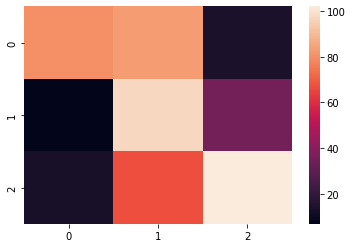

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_df.label, y_pred)
sns.heatmap(cm)

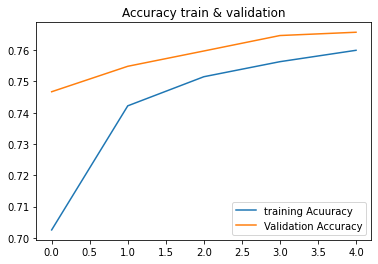

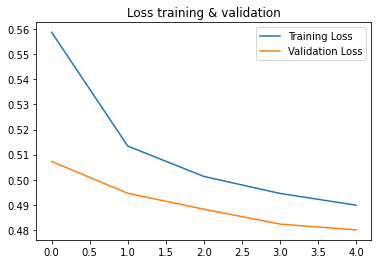

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = 5

plt.plot(acc, label="training Acuuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Accuracy train & validation")
plt.legend()
plt.figure()

plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss training & validation")
plt.legend()

plt.show()

In [27]:
txt = "I love the music"
predict = pad_sequences(tokenizer.texts_to_sequences([txt]), maxlen=30)
model.predict([predict])[0]

array([0.94851863], dtype=float32)

In [28]:
def sentiment_clf(sentiment_score):
    x = sentiment_score * 4
    if x > 3:
        return "pos"
    elif x < 1:
        return "neg"
    return "neu"

In [29]:
def predict(txt):
    predict = pad_sequences(tokenizer.texts_to_sequences([txt]), maxlen=30)
    x = model.predict([predict])
    return sentiment_clf(x[0])

In [30]:
predict('my heart is broken')

'neg'

In [31]:
predict('preyat is duck')

'neu'

In [32]:
predict('i am your father')

'neg'

In [33]:
predict('i loss my mom')

'neu'

In [34]:
predict('gpt is the best way to debug code')

'pos'

In [35]:
predict('hahaha')

'pos'

In [36]:
model.save("/kaggle/working/model.h5")

In [37]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [38]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)